<a href="https://colab.research.google.com/github/3lueLightning/tutorials/blob/main/rag_development_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
! pip install -q langchain langchain_community tiktoken langchain_openai langchain_text_splitters docarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 2.2 MB/s eta 0:00:00


# Loading the data
For this example we will be extracting the a list of the top 100 best movies of all time according to the magazin Empire. Let me know in the comments if you agree with the list ;)

## Set up the scraper

In [4]:
import os
from langchain_community.document_loaders import WebBaseLoader

# to improve our chances of not being blocked online we set a user agent to
# out crawler. This means
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36"


Testing that we can access the page with a simple HTTP request (working as a combination of `request.get` and `bs4.BeautifulSoup`), more info [here](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)

In [5]:
MOVIES_URL = "https://www.empireonline.com/movies/features/best-movies-2/"

full_page = WebBaseLoader(MOVIES_URL).load()
if not full_page:
  print("The page didn't load, but no worries we have a backup ;)")
else:
  print(full_page[0].page_content[:200])

'The 100 Best Movies Of All Time | Movies | %%channel_name%% MoviesReviewsNewsFeaturesTVGamingPodcastsEmpire VIPShoppingEmpire MagazineSubscribeManage My SubscriptionNewsletterHome|Movies|FeaturesThe 1'

SoupStainers allow us to extract information from a html without have to load everything in memory and then doing a find_all making it a more efficient option, more info [here](https://medium.com/codex/using-beautiful-soups-soupstrainer-to-save-time-and-memory-when-web-scraping-ea1dbd2e886f)

In [60]:
from bs4 import SoupStrainer

try:
  movie_scraper = WebBaseLoader(
      "https://www.continente.pt/", #MOVIES_URL,
      bs_kwargs = {
          "parse_only": SoupStrainer("div", class_="listicleItem_listicle-item__content__Lxn1Y")
      }
  )

  movie_reviews_raw = movie_scraper.load()
except:
  movie_reviews_raw = []

In [62]:
if not movie_reviews_raw or movie_reviews_raw[0].page_content != "\nMaking his uber cool":
  import pickle
  import urllib
  BACKUP_MOVIES_PKL_URL = "https://tutorials-public.s3.eu-west-1.amazonaws.com/movie_reviews_raw.pkl"
  with urllib.request.urlopen(BACKUP_MOVIES_PKL_URL) as response:
      movie_reviews_raw = pickle.load(response)

All the movie reviews come as a single document, but we want to split them and remove the links to the full movie reviews at the end of each block

In [8]:
from langchain.docstore.document import Document

def split_movies(page: Document) -> list[Document]:
  movie_reviews = page.page_content.strip().split("\n\n")
  movie_reviews = [reviews.split("\n")[0].strip() for reviews in movie_reviews]
  movie_docs = [
      Document(review, metadata={**page.metadata, "rank": i})
      for review, i in zip(movie_reviews, range(100, 0, -1))
  ]
  return movie_docs

In [9]:
movie_reviews = split_movies(movie_reviews_raw[0])
movie_reviews[0]

Document(page_content="Making his uber cool and supremely confident directorial debut, Quentin Tarantino hit audiences with a terrific twist on the heist-gone-wrong thriller. For the most part a single location chamber piece, Reservoir Dogs delights in ricocheting the zing and fizz of its dialogue around its gloriously —and indeed gore-iously) — intense setting, with the majority of the movie's action centring around one long and incredibly bloody death scene. Packing killer lines, killer needledrops, and killer, er, killers too, not only is this a rollicking ride in its own right, but it also set the blueprint for everything we've come to expect from a Tarantino joint. Oh, and by the way: Nice Guy Eddie was shot by Mr. White. Who fired twice. Case closed.", metadata={'source': 'https://www.empireonline.com/movies/features/best-movies-2/', 'rank': 100})

Embed the text

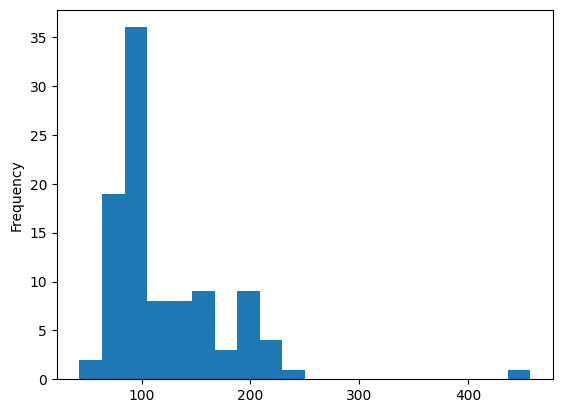

In [10]:
import tiktoken
import pandas as pd

def count_tokens(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

token_counts = pd.Series(
    [count_tokens(doc.page_content, "cl100k_base") for doc in movie_reviews]
)
token_counts.plot.hist(bins=20);

In [11]:
import numpy as np

movie_reviews[np.argmax(token_counts)].page_content

"A wizard is never late. Nor is he early. He arrives precisely when he... well, you know the rest. It might have taken 20 years for Peter Jackson's plucky fantasy to clamber, Mount-Doom-style, to the very pinnacle of our greatest-movies pantheon. But here it is, brighter and more resplendent than ever.The Fellowship Of The Ring contains so much movie. Even at the halfway point, as the characters take a breather to bicker in Rivendell, you already feel sated, like you've experienced more thrills, more suspense, more jollity and ethereal beauty than a regular film could possibly muster up. But Jackson is only getting started. Onwards his adventure hustles, to the bravura dungeoneering of Khazad-dum, to the sinisterly serene glades of Lothlorien, to the final requiem for flawed Boromir amidst autumnal leaves. As Fellowship thrums to its conclusion, finally applying the brakes with a last swell of Howard Shore's heavenly score, you're left feeling euphoric, bereft and hopeful, all at the s

Creating an embedding using Open API's models, more infor [here](https://platform.openai.com/docs/guides/embeddings)

In [12]:
import getpass
OPENAI_API_KEY = getpass.getpass()
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

··········


In [23]:
from langchain_openai import OpenAIEmbeddings

EMBEDDING_MODEL_NAME = "text-embedding-3-large"

embeder = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

# testing embeding
test_embedding = embeder.embed_query("What is 'Hello World'?")
print(test_embedding[:5])
print(f"the model {EMBEDDING_MODEL_NAME} generates embeddings of length: {len(test_embedding)}")

[-0.015830961987376213, -0.05633659288287163, -0.01440573763102293, 0.01969003491103649, -0.017862822860479355]
the model text-embedding-3-large generates embeddings of length: 3072


In [24]:
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch
from langchain_text_splitters import RecursiveCharacterTextSplitter
# docarray was imported earlier to avoid an error when using from_documents()


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    length_function=len,
)

index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeder,
    text_splitter=text_splitter,
).from_documents(movie_reviews)

In [25]:
movie_reviews[:2]

[Document(page_content="Making his uber cool and supremely confident directorial debut, Quentin Tarantino hit audiences with a terrific twist on the heist-gone-wrong thriller. For the most part a single location chamber piece, Reservoir Dogs delights in ricocheting the zing and fizz of its dialogue around its gloriously —and indeed gore-iously) — intense setting, with the majority of the movie's action centring around one long and incredibly bloody death scene. Packing killer lines, killer needledrops, and killer, er, killers too, not only is this a rollicking ride in its own right, but it also set the blueprint for everything we've come to expect from a Tarantino joint. Oh, and by the way: Nice Guy Eddie was shot by Mr. White. Who fired twice. Case closed.", metadata={'source': 'https://www.empireonline.com/movies/features/best-movies-2/', 'rank': 100}),
 Document(page_content="Bill Murray is at the height of his (eventually) lovable schmuck powers as narcissistic weatherman Phil Conn